In [1]:
# JUST FOR TESTING PURPOSES, DATASET CREATION IN run_gnn_model

In [2]:
import sys
#print(sys.path)
# sys.path.insert(0, '/eos/user/c/czeh/.local/lib/python3.9/site-packages')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

input_folder = "/eos/user/c/czeh/histo_10pion0PU"
output_folder = "/eos/user/c/czeh/graph_data"

The scikit-learn version is 1.5.1.
Python version
3.11.9 (main, Jun 24 2024, 14:32:54) [GCC 11.3.0]
Version info.
sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)


In [63]:
import os
from glob import glob
from tqdm import tqdm
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
from torch_geometric.data import Data
import torch_geometric
import networkx as nx

import awkward as ak
import numpy as np

print('The numpy version is {}.'.format(np.__version__))

import uproot as uproot
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
import scipy.spatial.distance
from sklearn.preprocessing import MaxAbsScaler
import torch.nn.functional as F

import joblib


from ClusterDataset import ClusterDataset
from torch_geometric.loader.dataloader import DataLoader

from graph_utils import build_ticl_graph
from data_statistics import plot_data_distribution


%matplotlib inline

The numpy version is 1.26.4.


## Load Data

In [4]:
# use this to load the tree if some of file.keys() are duplicates ending with different numbers
def load_branch_with_highest_cycle(file, branch_name):

    # Get all keys in the file
    all_keys = file.keys()

    # Filter keys that match the specified branch name
    matching_keys = [key for key in all_keys if key.startswith(branch_name)]

    if not matching_keys:
        raise ValueError(f"No branch with name '{branch_name}' found in the file.")

    # Find the key with the highest cycle
    highest_cycle_key = max(matching_keys, key=lambda key: int(key.split(";")[1]))

    # Load the branch with the highest cycle
    branch = file[highest_cycle_key]

    return branch

In [5]:
# input_folder = "/eos/user/a/aperego/SampleProduction/TICLv5/ParticleGunPion/histo"
files = glob(f"{input_folder}/train/*.root")
print(files[0])
file = uproot.open(files[0])
print(file.keys())

alltracksters = load_branch_with_highest_cycle(file,'ticlDumper/ticlTrackstersCLUE3DHigh')
allclusters = load_branch_with_highest_cycle(file,'ticlDumper/clusters')
allsimtrackstersCP = load_branch_with_highest_cycle(file, 'ticlDumper/simtrackstersCP')
allassociations = load_branch_with_highest_cycle(file, 'ticlDumper/associations')
print(alltracksters.show())

/eos/user/c/czeh/histo_10pion0PU/train/histo_7453673_0.root
['ticlDumper;1', 'ticlDumper/ticlTrackstersCLUE3DHigh;1', 'ticlDumper/ticlTracksterLinks;1', 'ticlDumper/ticlCandidate;1', 'ticlDumper/ticlTracksterLinksSuperclusteringDNN;1', 'ticlDumper/simtrackstersSC;1', 'ticlDumper/simtrackstersCP;1', 'ticlDumper/clusters;1', 'ticlDumper/candidates;1', 'ticlDumper/superclustering;1', 'ticlDumper/associations;1', 'ticlDumper/tracks;1', 'ticlDumper/simTICLCandidate;1']
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | edm::EventID             | AsGroup(<TBranchElement 'ev...
event/run_           | uint32_t                 | AsDtype('>u4')
event/luminosityB... | uint32_t                 | AsDtype('>u4')
event/event_         | uint64_t                 | AsDtype('>u8')
NTracksters          | uint32_t                 | AsDtype('>u4')
NClusters            | uint3

In [6]:
len(alltracksters.arrays())

40

In [7]:
node_feature_keys_before = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "raw_energy", "raw_em_energy", "time"]
data = alltracksters.arrays(node_feature_keys_before)
data

<Array [{barycenter_x: [...], ...}, ..., {...}] type='40 * {barycenter_x: v...'>

## Prepare Feature Data

In [8]:
alltracksters_array = alltracksters.arrays()
allassociations_array = allassociations.arrays()
cluster_number_of_hits = allclusters.arrays().cluster_number_of_hits
cluster_layer_id = allclusters.arrays().cluster_layer_id
vertices_indexes = alltracksters.arrays().vertices_indexes
NTracksters = alltracksters.arrays().NTracksters

In [9]:
try:
    allgraph = self.load_branch_with_highest_cycle(file, 'ticlDumper/TICLGraph')
    allgraph_array = allgraph.arrays()
except:
    allgraph = []
    for i in range(len(NTracksters)):
        allgraph.append(build_ticl_graph(NTracksters[i], alltracksters_array[i]))
    allgraph_array = ak.Array(allgraph)

In [10]:
data["vertices"] = ak.concatenate([alltracksters_array["vertices_x"][:, :, :, np.newaxis], alltracksters_array["vertices_y"][:, :, :, np.newaxis], alltracksters_array["vertices_z"][:, :, :, np.newaxis]], axis=-1)

In [11]:
data["vertices"][0]

<Array [[[54.1, 29.6, -322], ..., [...]], ...] type='251 * var * 3 * float32'>

In [12]:
num_LCs = ak.count(alltracksters.arrays().vertices_indexes, axis=2)
data["num_LCs"] = num_LCs

In [13]:
data["z_min"] = ak.min(alltracksters.arrays().vertices_z, axis=2)
data["z_max"] = ak.max(alltracksters.arrays().vertices_z, axis=2)


In [14]:
volume = 2*(3 - 1.5) * (2 * 47)
data["trackster_density"] = ak.Array(np.zeros_like(data.num_LCs)) + NTracksters / volume
data["LC_density"] = data.num_LCs / volume

In [15]:
hits = ak.to_list(np.zeros_like(data.num_LCs))
length = ak.to_list(np.zeros_like(data.num_LCs))

cluster_hits = cluster_number_of_hits[ak.flatten(vertices_indexes, axis=-1)]
cluster_layer_ids = cluster_layer_id[ak.flatten(vertices_indexes, axis=-1)]
vertices_count = ak.count(vertices_indexes, axis=-1)

for i in range(len(alltracksters.arrays())):
    hits[i] = ak.sum(ak.unflatten(cluster_hits[i], vertices_count[i]), axis=-1)
    length[i] = (ak.max(ak.unflatten(cluster_layer_ids[i], vertices_count[i]), axis=-1) - ak.min(ak.unflatten(cluster_layer_ids[i], vertices_count[i]), axis=-1)) / 47
        
data["num_hits"] = hits
data["length"] = length

In [16]:
data["photon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 0]
data["electron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 1]
data["muon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 2]
data["neutral_pion_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 3]
data["charged_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 4]
data["neutral_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 5]

In [17]:
idx = allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_score<0.2
simTracksters = allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP[allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_score<0.2]
emptys = np.full_like(ak.count(allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP, axis=-1), -1) 

data["y"] = ak.flatten(ak.where(ak.count(simTracksters, axis=-1)==1, allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP[idx], ak.unflatten(emptys, 1, axis=-1)), axis=-1)
data["shared_e"] = ak.flatten(ak.where(ak.count(simTracksters, axis=-1)==1, allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_sharedE[idx], ak.unflatten(emptys, 1, axis=-1)), axis=-1)
data["score"] = ak.flatten(ak.where(ak.count(simTracksters, axis=-1)==1, allassociations_array.ticlTrackstersCLUE3DHigh_recoToSim_CP_score[idx], ak.unflatten(emptys, 1, axis=-1)), axis=-1)

In [18]:
data["y"]

<Array [[19, 2, 2, 2, 2, ..., 17, 17, 17, 17, 17], ...] type='40 * var * int64'>

In [19]:
node_feature_keys = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "num_LCs", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "length", "LC_density", "trackster_density", "time"]

In [20]:
node_feature_keys_plot = ["barycenter_x", "barycenter_y", "barycenter_z", "y", "score", "shared_e", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "num_LCs", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "length", "LC_density", "trackster_density", "time"]
node_feature_names_plot = ["x", "y", "z", "sim_trackster", "sim_trackster_score", "sim_trackster_shared_energy", "eta", "phi", "eig_x", "eig_y", "eig_z",  "EV1", "EV2", "EV3", "sigmaPCA_x", "sigmaPCA_y", "sigmaPCA_z", "num_LC", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "length", "LC_density", "trackster_density", "time"]

100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
/tmp/ipykernel_1203/2186559242.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


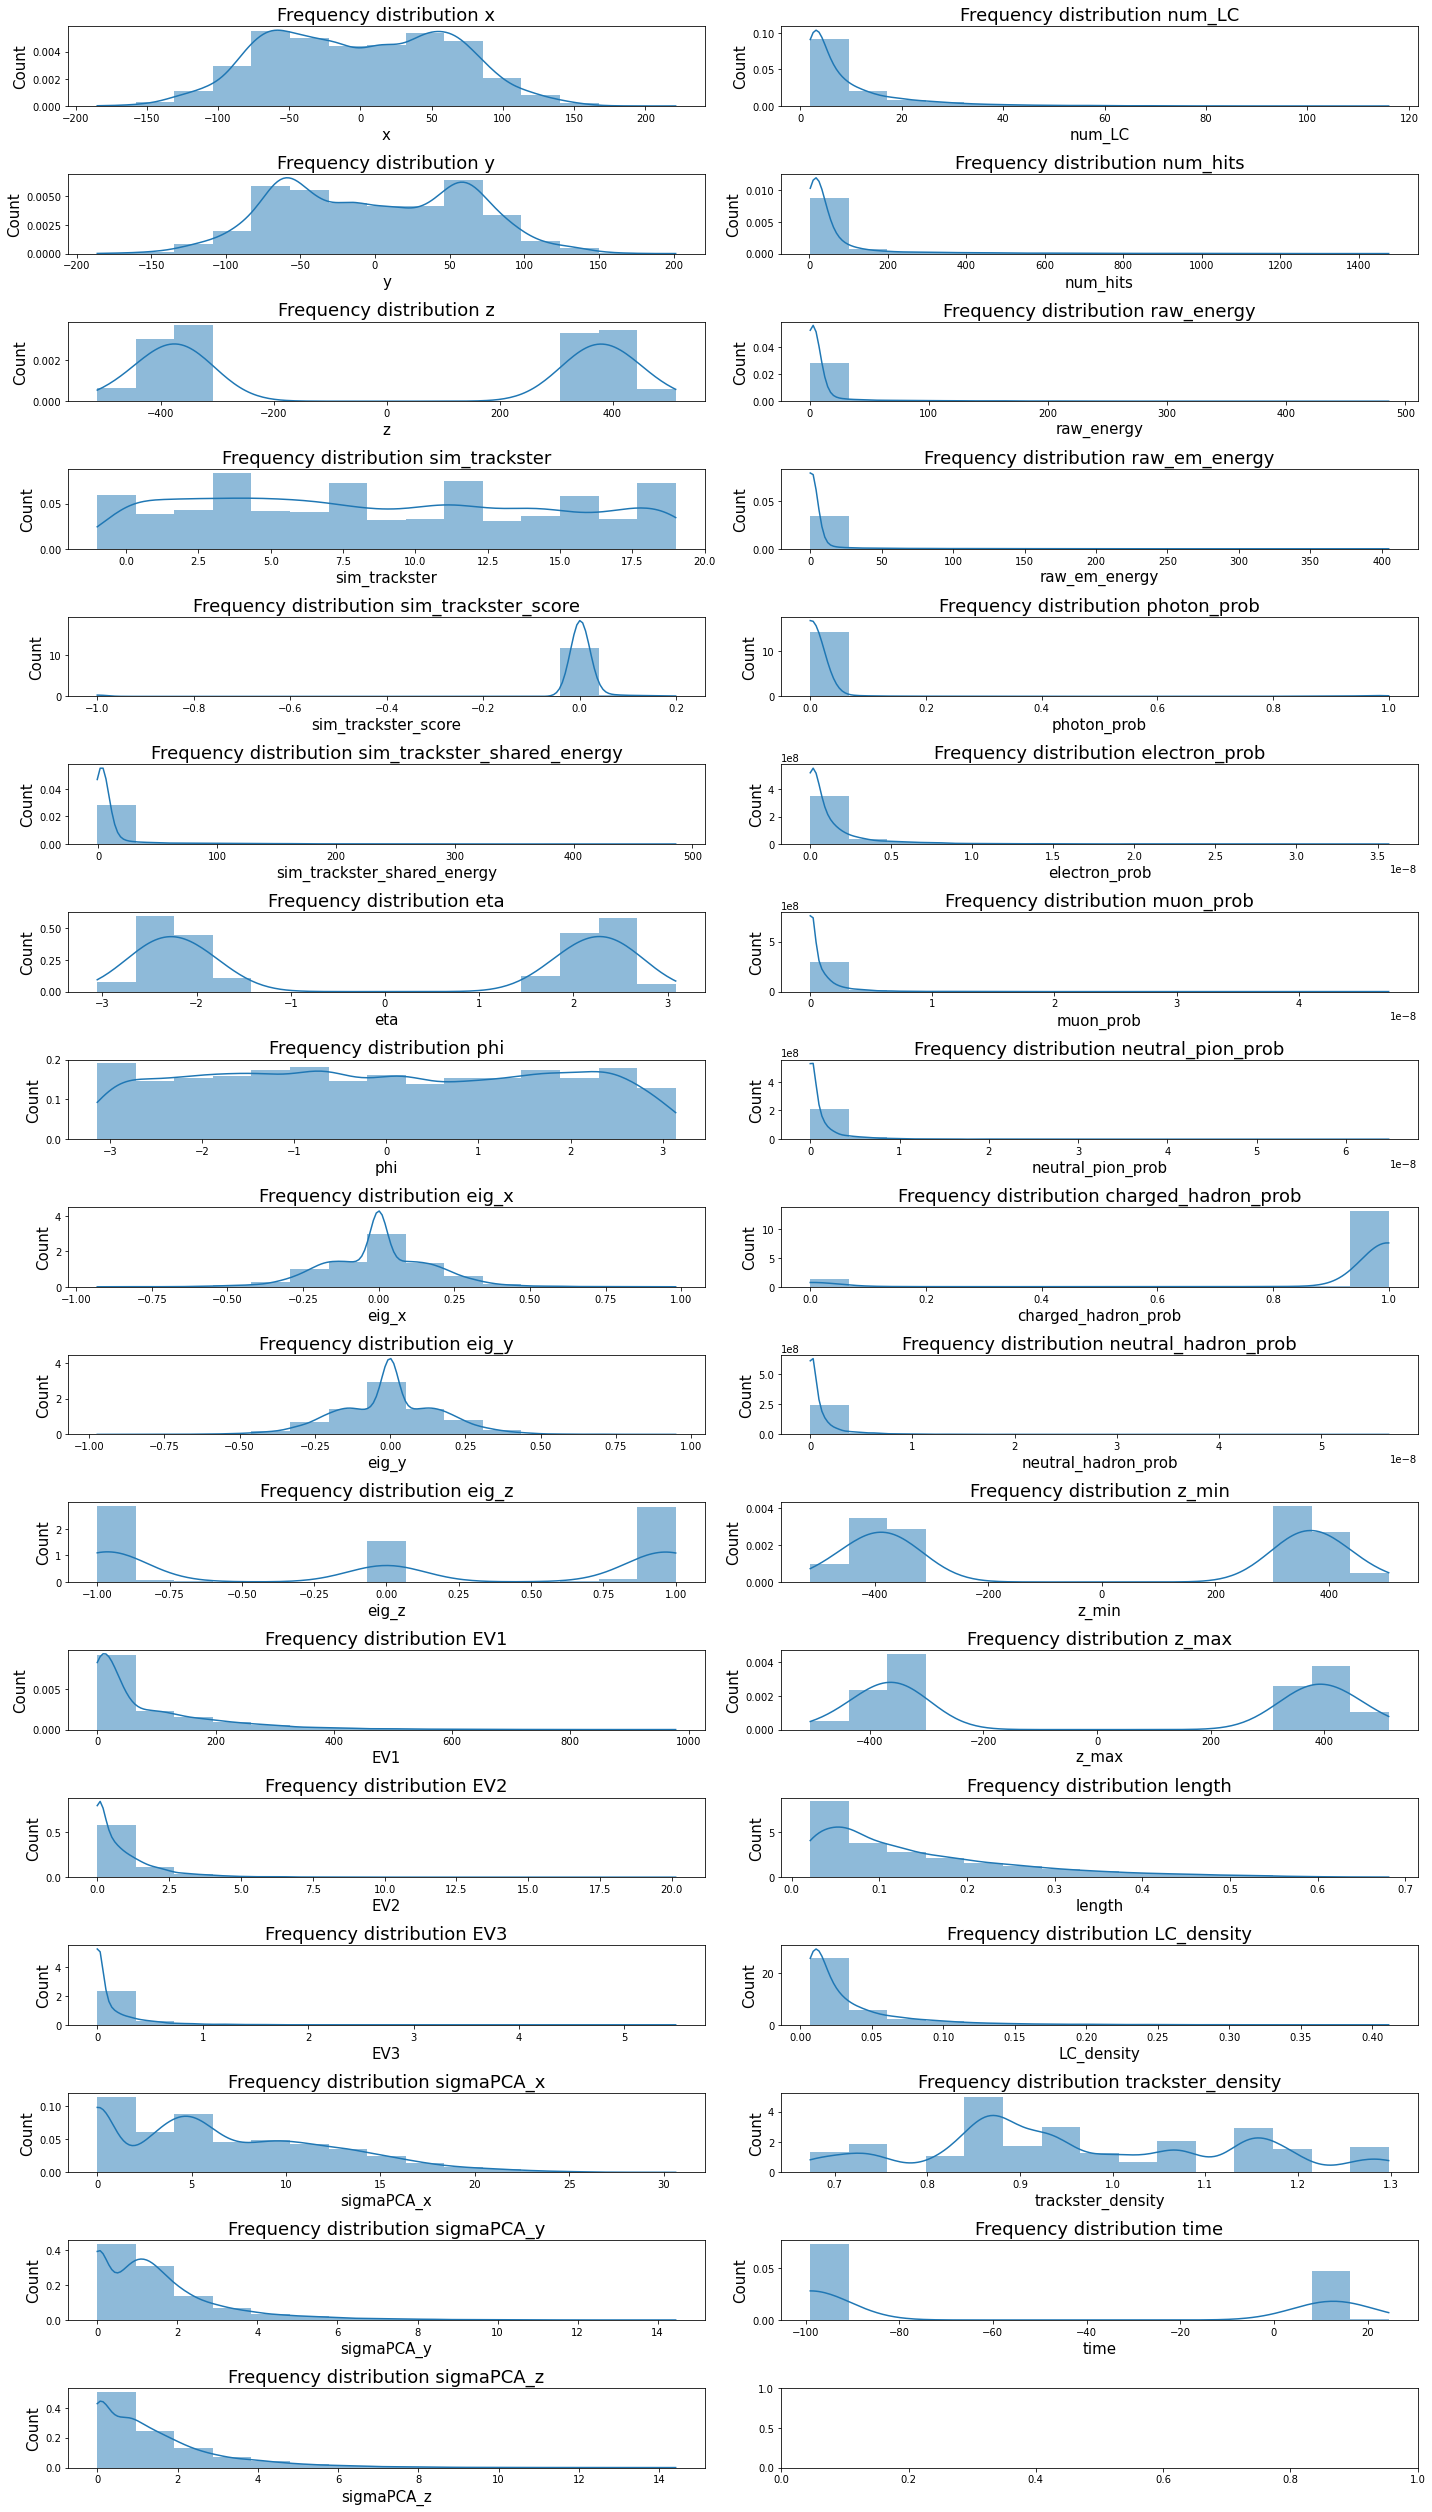

In [21]:
track_vals = []

scols = int(np.ceil(len(node_feature_keys_plot)/2))
srows = 2
fig, axes = plt.subplots(scols, srows, figsize=(20, 35), constrained_layout=True)

for i in tqdm(range(len(node_feature_keys_plot))):
    ax_col = int(i%scols)
    ax_row = int(i/scols)
    
    values = ak.flatten(data[node_feature_keys_plot[i]])
    track_vals.append(values)
    sns.histplot(values, ax=axes[ax_col, ax_row], kde=True, stat="density", linewidth=0, bins=15)
    axes[ax_col, ax_row].set_title('Frequency distribution '+ node_feature_names_plot[i], fontsize=18)
    axes[ax_col, ax_row].set_xlabel(node_feature_names_plot[i], fontsize=15)
    axes[ax_col, ax_row].set_ylabel('Count', fontsize=15)
    
fig.tight_layout()
plt.show()

In [22]:
track_vals = np.array(track_vals)
track_vals

array([[ 5.70012970e+01, -5.24252892e+01, -4.29902039e+01, ...,
        -6.65044327e+01,  1.54993484e+02,  1.32267670e+02],
       [ 2.93051929e+01, -1.45495424e+01, -2.79194508e+01, ...,
        -4.02688828e+01, -1.09924232e+02,  8.41368713e+01],
       [-3.27907898e+02, -3.29081635e+02, -3.29248566e+02, ...,
         4.81091888e+02,  4.98305511e+02,  5.05305176e+02],
       ...,
       [ 8.15602837e-02,  1.56028369e-01,  4.96453901e-02, ...,
         7.09219858e-03,  1.41843972e-02,  1.41843972e-02],
       [ 8.90070922e-01,  8.90070922e-01,  8.90070922e-01, ...,
         1.07446809e+00,  1.07446809e+00,  1.07446809e+00],
       [-9.90000000e+01,  1.14941998e+01, -9.90000000e+01, ...,
        -9.90000000e+01, -9.90000000e+01, -9.90000000e+01]])

In [23]:
corr_matrix = np.corrcoef(track_vals)
print(corr_matrix.shape)

(33, 33)


Text(0.5, 1.0, 'Correlation Matrix of the Trackster Features')

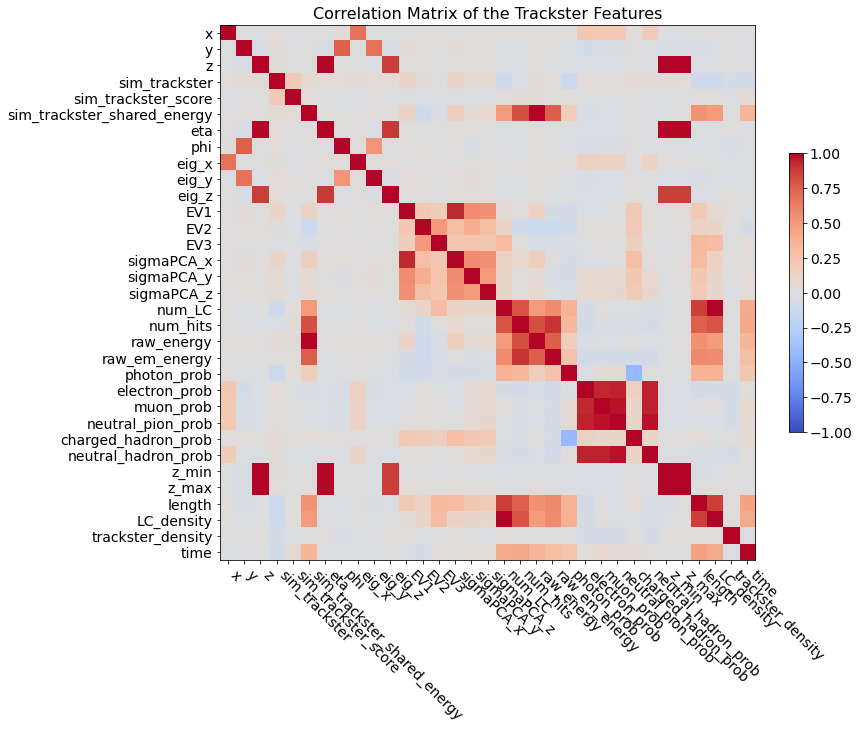

In [24]:
f = plt.figure(figsize=(12, 10))
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(range(len(node_feature_names_plot)), node_feature_names_plot, fontsize=14, rotation=-45, ha="left")
plt.yticks(range(len(node_feature_names_plot)), node_feature_names_plot, fontsize=14)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of the Trackster Features', fontsize=16)

## Check no PileUp

Text(0.5, 0, 'z (cm)')

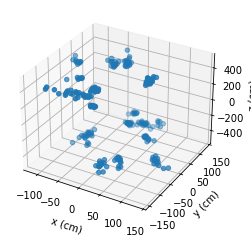

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0].barycenter_x, data[0].barycenter_y, data[0].barycenter_z)

ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('z (cm)')

## Normalize Data

In [26]:
node_feature_dict = {k: v for v, k in enumerate(node_feature_keys)}
standard_norm_keys = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z", "EV1", "EV2", "EV3",
                         "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "num_LCs", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob",
                         "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "LC_density", "trackster_density", "time"]

In [27]:
start = 1
for event in range(10):    
    nodes = np.zeros((NTracksters[event], len(node_feature_keys)))
    for i, key in enumerate(node_feature_keys):
        nodes[:, i] = ak.to_numpy(data[event][key])            
    
    if start == 1:
        X = pd.DataFrame(nodes, columns=node_feature_keys)
        start = 0
    else:
        Y = pd.DataFrame(nodes, columns=node_feature_keys)
        X = pd.concat([X, Y], ignore_index=True)

X

,barycenter_x,barycenter_y,barycenter_z,barycenter_eta,barycenter_phi,eVector0_x,eVector0_y,eVector0_z,EV1,EV2,...,muon_prob,neutral_pion_prob,charged_hadron_prob,neutral_hadron_prob,z_min,z_max,length,LC_density,trackster_density,time
0,57.001297,29.305193,-327.907898,-2.334958,0.474875,0.475606,0.043886,-0.878563,26.011724,1.876846,...,3.195815e-10,3.328837e-10,0.994274,2.652179e-10,-338.433990,-322.154999,0.234043,0.081560,0.890071,-99.0000
1,-52.425289,-14.549542,-329.081635,-2.499727,-2.870877,-0.250491,-0.119729,-0.960687,19.658138,0.850215,...,1.098855e-09,6.023964e-10,0.973863,3.675695e-10,-347.605011,-322.154999,0.361702,0.156028,0.890071,11.4942
2,-42.990204,-27.919451,-329.248566,-2.559041,-2.565613,-0.112175,-0.055730,-0.992125,15.823715,1.042941,...,3.592313e-10,4.240343e-10,0.996645,4.465848e-10,-335.377014,-322.154999,0.191489,0.049645,0.890071,-99.0000
3,-48.144363,-23.426392,-329.237000,-2.516017,-2.688733,-0.149379,-0.043175,-0.987837,25.773720,0.835879,...,3.626157e-10,2.906284e-10,0.993336,2.797836e-10,-347.605011,-322.154999,0.361702,0.081560,0.890071,-99.0000
4,-51.239979,-1.239643,-326.428650,-2.550653,-3.117404,-0.159635,0.110782,-0.980940,12.947741,0.171609,...,2.073076e-10,3.161244e-10,0.997431,3.248455e-10,-335.377014,-322.154999,0.191489,0.042553,0.890071,-99.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,-104.171799,5.981233,494.706055,2.260365,3.084239,-0.136170,0.106726,0.984920,198.918533,1.341971,...,7.366938e-14,1.023633e-13,0.999983,2.888702e-13,472.151001,504.855988,0.085106,0.010638,0.755319,-99.0000
2602,48.734684,-117.486694,497.950165,2.073864,-1.177588,0.230036,-0.364226,0.902454,111.220032,12.039515,...,6.770118e-14,6.133664e-14,0.999991,1.258455e-13,488.406006,513.081055,0.063830,0.014184,0.755319,-99.0000
2603,-113.409836,8.496722,505.757355,2.197805,3.066812,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.797125e-13,4.769280e-13,0.999959,1.145947e-12,504.855988,513.081055,0.021277,0.007092,0.755319,-99.0000
2604,32.883141,-113.209045,504.873230,2.161079,-1.288111,0.290503,-0.005828,0.956856,37.237946,16.548519,...,1.531843e-14,1.223628e-14,0.999996,2.803756e-14,496.630981,513.081055,0.042553,0.010638,0.755319,-99.0000


In [35]:
scaler = MaxAbsScaler()
scaler.fit(X)
joblib.dump(scaler, "/eos/user/c/czeh/graph_data/scaler.joblib")

['/eos/user/c/czeh/graph_data/scaler.joblib']

In [38]:
X/scaler.scale_

,barycenter_x,barycenter_y,barycenter_z,barycenter_eta,barycenter_phi,eVector0_x,eVector0_y,eVector0_z,EV1,EV2,...,muon_prob,neutral_pion_prob,charged_hadron_prob,neutral_hadron_prob,z_min,z_max,length,LC_density,trackster_density,time
0,0.312302,0.170703,-0.648350,-0.756841,0.151161,0.484484,0.045105,-0.878587,0.029796,0.113415,...,8.496761e-03,5.413844e-03,0.994275,7.406385e-03,-0.659611,-0.627645,0.34375,0.198276,0.777090,-1.000000
1,-0.287231,-0.084751,-0.650671,-0.810248,-0.913848,-0.255167,-0.123056,-0.960714,0.022518,0.051377,...,2.921543e-02,9.797055e-03,0.973864,1.026462e-02,-0.677486,-0.627645,0.53125,0.379310,0.777090,0.116103
2,-0.235537,-0.162631,-0.651001,-0.829474,-0.816677,-0.114269,-0.057279,-0.992152,0.018126,0.063023,...,9.550936e-03,6.896268e-03,0.996646,1.247118e-02,-0.653653,-0.627645,0.28125,0.120690,0.777090,-1.000000
3,-0.263776,-0.136459,-0.650978,-0.815529,-0.855869,-0.152168,-0.044375,-0.987864,0.029523,0.050511,...,9.640917e-03,4.726625e-03,0.993337,7.813143e-03,-0.677486,-0.627645,0.53125,0.198276,0.777090,-1.000000
4,-0.280736,-0.007221,-0.645425,-0.826755,-0.992322,-0.162615,0.113860,-0.980968,0.014831,0.010370,...,5.511718e-03,5.141279e-03,0.997431,9.071527e-03,-0.653653,-0.627645,0.28125,0.103448,0.777090,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,-0.570742,0.034841,0.978149,0.732663,0.981765,-0.138711,0.109692,0.984947,0.227856,0.081093,...,1.958659e-06,1.664783e-06,0.999984,8.066892e-06,0.920227,0.983596,0.12500,0.025862,0.659443,-1.000000
2602,0.267010,-0.684360,0.984563,0.672211,-0.374846,0.234330,-0.374346,0.902479,0.127400,0.727528,...,1.799981e-06,9.975465e-07,0.999992,3.514319e-06,0.951908,0.999620,0.09375,0.034483,0.659443,-1.000000
2603,-0.621356,0.049493,1.000000,0.712385,0.976217,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.009547e-05,7.756503e-06,0.999960,3.200133e-05,0.983969,0.999620,0.03125,0.017241,0.659443,-1.000000
2604,0.180162,-0.659443,0.998252,0.700481,-0.410027,0.295926,-0.005990,0.956883,0.042655,1.000000,...,4.072734e-07,1.990044e-07,0.999996,7.829675e-07,0.967939,0.999620,0.06250,0.025862,0.659443,-1.000000


In [40]:
pd.DataFrame(scaler.transform(X), columns=node_feature_keys)

,barycenter_x,barycenter_y,barycenter_z,barycenter_eta,barycenter_phi,eVector0_x,eVector0_y,eVector0_z,EV1,EV2,...,muon_prob,neutral_pion_prob,charged_hadron_prob,neutral_hadron_prob,z_min,z_max,length,LC_density,trackster_density,time
0,0.312302,0.170703,-0.648350,-0.756841,0.151161,0.484484,0.045105,-0.878587,0.029796,0.113415,...,8.496761e-03,5.413844e-03,0.994275,7.406385e-03,-0.659611,-0.627645,0.34375,0.198276,0.777090,-1.000000
1,-0.287231,-0.084751,-0.650671,-0.810248,-0.913848,-0.255167,-0.123056,-0.960714,0.022518,0.051377,...,2.921543e-02,9.797055e-03,0.973864,1.026462e-02,-0.677486,-0.627645,0.53125,0.379310,0.777090,0.116103
2,-0.235537,-0.162631,-0.651001,-0.829474,-0.816677,-0.114269,-0.057279,-0.992152,0.018126,0.063023,...,9.550936e-03,6.896268e-03,0.996646,1.247118e-02,-0.653653,-0.627645,0.28125,0.120690,0.777090,-1.000000
3,-0.263776,-0.136459,-0.650978,-0.815529,-0.855869,-0.152168,-0.044375,-0.987864,0.029523,0.050511,...,9.640917e-03,4.726625e-03,0.993337,7.813143e-03,-0.677486,-0.627645,0.53125,0.198276,0.777090,-1.000000
4,-0.280736,-0.007221,-0.645425,-0.826755,-0.992322,-0.162615,0.113860,-0.980968,0.014831,0.010370,...,5.511718e-03,5.141279e-03,0.997431,9.071527e-03,-0.653653,-0.627645,0.28125,0.103448,0.777090,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,-0.570742,0.034841,0.978149,0.732663,0.981765,-0.138711,0.109692,0.984947,0.227856,0.081093,...,1.958659e-06,1.664783e-06,0.999984,8.066892e-06,0.920227,0.983596,0.12500,0.025862,0.659443,-1.000000
2602,0.267010,-0.684360,0.984563,0.672211,-0.374846,0.234330,-0.374346,0.902479,0.127400,0.727528,...,1.799981e-06,9.975465e-07,0.999992,3.514319e-06,0.951908,0.999620,0.09375,0.034483,0.659443,-1.000000
2603,-0.621356,0.049493,1.000000,0.712385,0.976217,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.009547e-05,7.756503e-06,0.999960,3.200133e-05,0.983969,0.999620,0.03125,0.017241,0.659443,-1.000000
2604,0.180162,-0.659443,0.998252,0.700481,-0.410027,0.295926,-0.005990,0.956883,0.042655,1.000000,...,4.072734e-07,1.990044e-07,0.999996,7.829675e-07,0.967939,0.999620,0.06250,0.025862,0.659443,-1.000000


/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/data_statistics.py:86: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


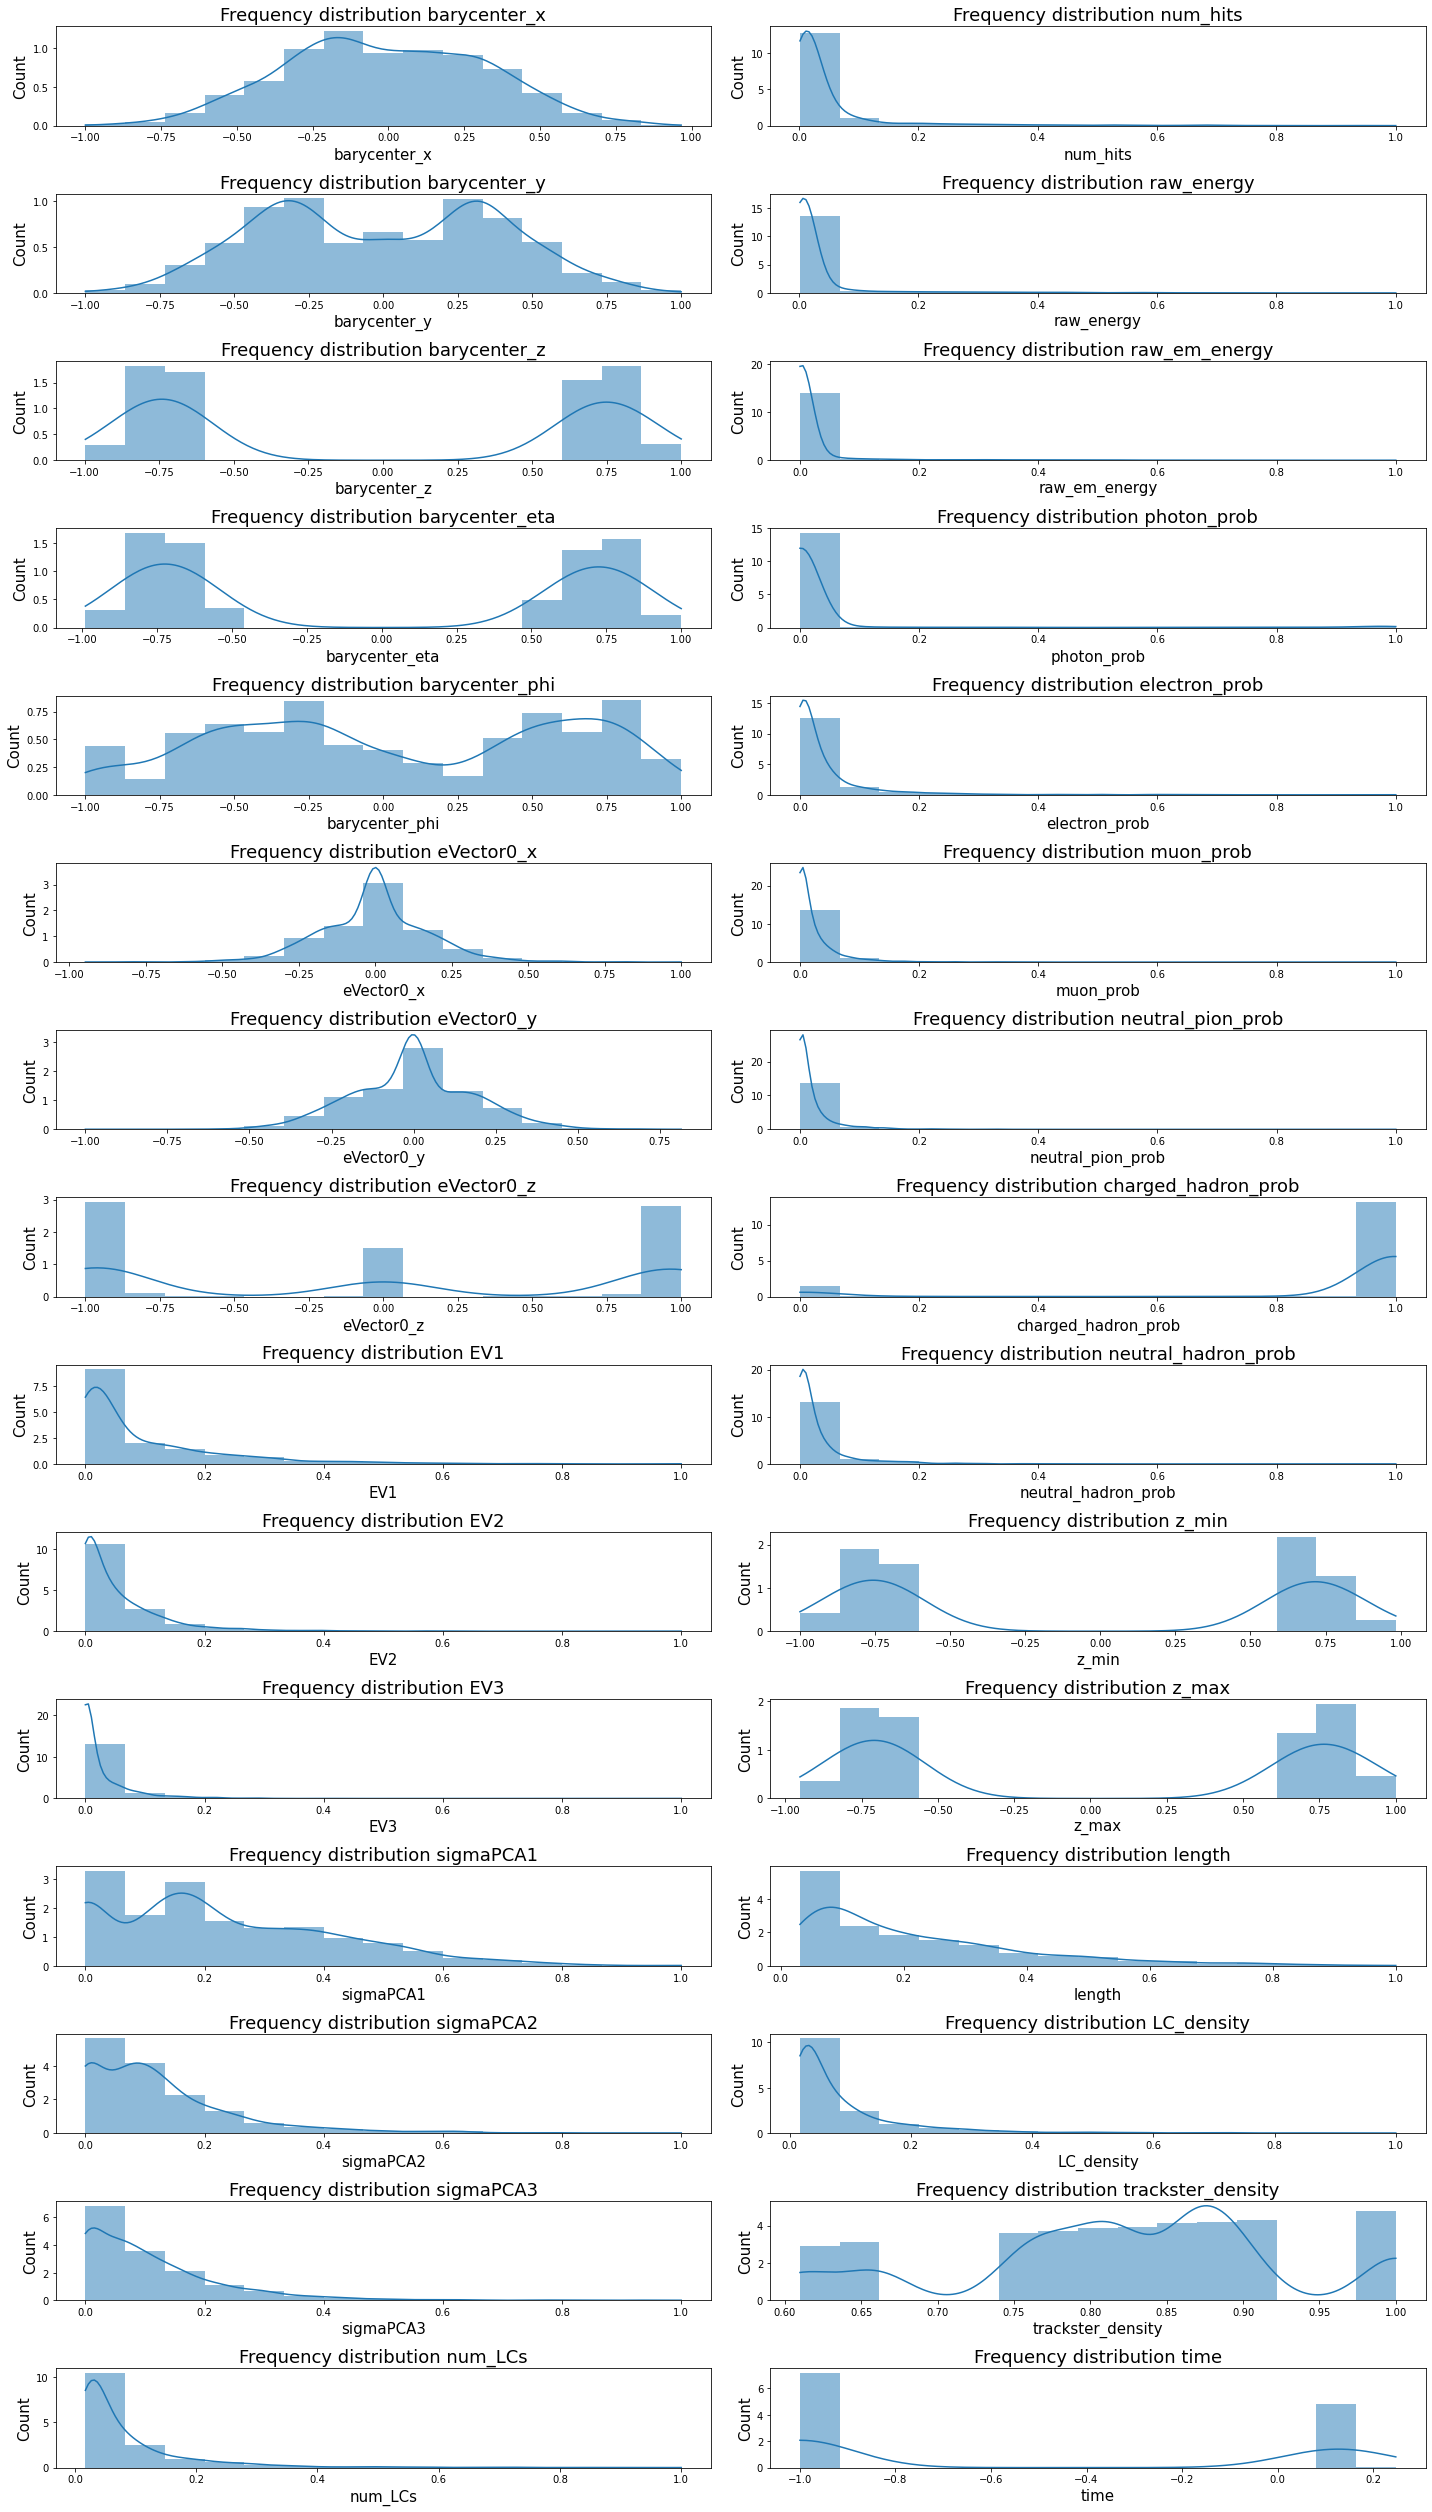

In [36]:
loaded_scaler = joblib.load("/eos/user/c/czeh/graph_data/scaler.joblib")
X_mm = pd.DataFrame(loaded_scaler.transform(X), columns=node_feature_keys)
plot_data_distribution(X_mm, node_feature_keys)

In [58]:
filtered_X = X[["barycenter_eta", "barycenter_phi", "raw_energy"]]
filtered_tensor = torch.unsqueeze(torch.tensor(X.to_numpy()), dim=0)
filtered_tensor.shape

torch.Size([1, 2606, 30])

In [64]:
filtered_tensor = F.pad(filtered_tensor, pad=(0, 0, 5, 0), value=0)

In [67]:
filtered_tensor[torch.sum(filtered_tensor, dim=2) != 0].shape

torch.Size([2606, 30])

In [68]:
src_mask = (torch.sum(filtered_tensor, dim=2) != 0).unsqueeze(1).unsqueeze(2)
src_mask

tensor([[[[False, False, False,  ...,  True,  True,  True]]]])

## Create Graph Data

In [ ]:
roots = ak.num(allgraph_array.inner, axis=-1)
data["roots"] = ak.local_index(roots)[roots  == 0]

In [ ]:
data["idx"] = ak.local_index(data.barycenter_x)

In [ ]:
graph_list = []
for event in range(10):    
    nodes = np.zeros((NTracksters[event], len(node_feature_keys)))
    for i, key in enumerate(node_feature_keys):
        nodes[:, i] = ak.to_numpy(data[event][key])

    # Create base graph from geometrical graph    
    edges = [[], []]
    for i in range(NTracksters[event]):
        edges[0].extend([i] * len(allgraph_array[event].outer[i]))    
        edges[1].extend(allgraph_array[event].outer[i])
        
    edges = np.array(edges)
    
    edge_features = np.zeros((len(edges[0, :]), 7))
    edge_features[:, 4] = np.linalg.norm(nodes[edges[1, :], :2] - nodes[edges[0, :], :2], axis=1)
    
    edge_features[:, 0] = np.abs(nodes[edges[1, :], 16] - nodes[edges[0, :], 16])
    edge_features[:, 1] = np.abs(nodes[edges[1, :], 2] - nodes[edges[0, :], 2])
    edge_features[:, 5] = np.arccos(np.clip(np.sum(np.multiply(nodes[edges[1, :], 5:8], nodes[edges[0, :], 5:8]), axis=1), a_min=-1, a_max=1))
    edge_features[:, 6] = np.abs(nodes[edges[1, :], 28] - nodes[edges[0], 28])
    
    # y
    y = np.zeros(edges.shape[1])
    for i, e in enumerate(edges.T):
        if((data[event].y[e[0]] != -1) and (data[event].y[e[0]] == data[event].y[e[1]])):
            y[i] = (1-data[event].score[e[0]]) * data[event].shared_e[e[0]]/data[event].raw_energy[e[0]] + (1-data[event].score[e[1]]) * data[event].shared_e[e[1]]/data[event].raw_energy[e[1]]
            
    graph_list.append(Data(x=torch.from_numpy(nodes), num_nodes=NTracksters[event],
                        edge_index=torch.from_numpy(edges), edges_features=edge_features, y=torch.from_numpy(y),
                          y_trans = data["y"][event]))

In [ ]:
graph_list

## Prepare Slow Edge Data
Not in Graph Data, as way to slow just for tests

In [ ]:
transp = edges.T
edge_indices = np.zeros((NTracksters[event], NTracksters[event], ), dtype=np.int64)

for i in range(len(edges[0, :])):
    edge_indices[transp[i, 0], transp[i, 1]] = i

In [ ]:
for root in range(edge_indices.shape[0]):
    tree = KDTree(data["vertices"][0, root], leaf_size=2)
    num = len(data["vertices"][0, root])
    for target in range(edge_indices.shape[1]):
        if (edge_indices[root, target] == -1):
            continue
        if (root != target):
            dist, _ = tree.query(data["vertices"][0, target], k=num)
            edge_features[edge_indices[root, target], 2] = np.min(dist)
            edge_features[edge_indices[root, target], 3] = np.max(dist)

            edge_features[edge_indices[target, root], 2] = np.min(dist)
            edge_features[edge_indices[target, root], 3] = np.max(dist)
        else:
            edge_features[edge_indices[root, target], 2] = 0
            edge_features[edge_indices[root, target], 3] = 0

In [ ]:
print(np.mean(edge_features[:, 4]))
print(np.median(edge_features[:, 4]))
print(np.min(edge_features[:, 4]))
print(np.max(edge_features[:, 4]))

## Analyse Dataset

In [ ]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo/"
data_folder_training = "/eos/user/c/czeh/graph_data"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder)
dataset_test = ClusterDataset(data_folder_test, hist_folder, test=True)

In [ ]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [ ]:
len(train_dl)

### Distribution of Score value -> How many Edges 0?

In [ ]:
val_counts = {}

for sample in test_dl:
    unique, counts = np.unique(sample.y, return_counts=True)
    
    for i, val in enumerate(unique):
        if val in val_counts:
            val_counts[val] += counts[i]
        else:
            val_counts[val] = counts[i]
val_counts

## Analyze Subgraph building

In [ ]:
from lang import Lang

In [ ]:
max_nodes = 255
input_length = 20
converter = Lang(max_nodes)

In [ ]:
converter.word2index.keys()

In [ ]:
def build_subgraph(graph, root, neighborhood=1):
        neighbors = graph[1][graph[0] == root]
        neighbors = torch.cat((neighbors, graph[0][graph[1] == root]))

        if (neighborhood == 0):
            return neighbors
        subgraph = np.copy(neighbors)

        for n in neighbors:
            subgraph = np.append(subgraph, build_subgraph(graph, n, neighborhood-1))

        return np.unique(subgraph)

In [ ]:
data_idx = 14
X = dataset_training.get(data_idx)
X

In [ ]:
X.roots

In [ ]:
G = torch_geometric.utils.to_networkx(X, to_undirected=True)
newData = Data(x=X.x, num_nodes=X.num_nodes, edge_index=X.edge_index[:, X.y > 0])
newG = torch_geometric.utils.to_networkx(newData, to_undirected=True)

pos = dict(zip(list(range(X.num_nodes)), X.x[:, :2]))

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
nx.draw(G, with_labels=True, ax=ax[0], pos=pos, node_size=X.x[:, 16]*5)
nx.draw(newG, with_labels=True, ax=ax[1], pos=pos, node_size=X.x[:, 16]*5)

Cycle trough a full sequence creation by hand:

In [ ]:
roots = X.roots[np.argsort(-X.x[X.roots, 16])]
roots

In [ ]:
root = roots[0].item()

In [ ]:
root_subgraph = np.array(build_subgraph(X.edge_index, root, 1), dtype=int)
root_subgraph = root_subgraph[np.argsort(-X.x[root_subgraph, 16])]
root_subgraph

In [ ]:
sorted_graph = np.array(np.argsort(-X.x[:, 16]), dtype=int)
sorted_graph

In [ ]:
if (root_subgraph.shape[0] > 1):
    root_group = sorted_graph[X.cluster[sorted_graph] == X.cluster[root].item()]
else:
    root_group = sorted_graph
root_group

In [ ]:
sample_seq = converter.y2seq(root, sorted_graph, np.array(X.cluster))
sample_seq

In [ ]:
i = -1
visited = []

In [ ]:
i = sample_seq.shape[0]-3
seq = converter.subseq(sample_seq, seq_length=input_length, index=i-input_length+2)
seq

In [ ]:
seq[-1]

In [ ]:
subgraph = np.array([])
if (seq[-1] > converter.word2index[";"]):
    new_root = int(converter.index2word[seq[-1]])
    subgraph = np.array(build_subgraph(X.edge_index, new_root, 2), dtype=int)
    subgraph = np.array(subgraph, dtype=int)
    
    subgraph = np.setdiff1d(subgraph, np.array(visited))
    visited.append(seq[-1])
subgraph

In [ ]:
np.array(visited)

In [ ]:
if (subgraph.shape[0] > 1):
    group = subgraph[X.cluster[subgraph] == X.cluster[new_root].item()]
    group = np.setdiff1d(group, visited)
    
    if (group.shape[0] == 0):
        group = sample_seq[i+2]
elif(subgraph.shape[0] == 1):
    group = subgraph
else:
    group = sample_seq[i+2]

## Graph Components

In [ ]:
from ClusterDataset import ClusterDataset
from graph_utils import find_connected_components
import plotly.graph_objects as go

import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [ ]:
data_folder_training = "/eos/user/c/czeh/graph_data"
hist_folder = "/eos/user/c/czeh/histo/"
dataset_training = ClusterDataset(data_folder_training, hist_folder)

In [ ]:
data_idx = 0
X = dataset_training.get(data_idx)
print(X.x.shape)

In [ ]:
edges = []
nodes = []
roots = []

components = find_connected_components(X.edge_index, X.x.shape[0])

for component in components:
    component = np.array(component, dtype=int)
    if (component.shape[0] <= 1):
        continue
    
    root = torch.argmax(X.x[component, 16]).item()
    root_cluster = X.cluster[root].item()
    sample_seq = converter.y2seq(root, component, np.array(X.cluster))   
    print(sample_seq)
    seq = np.array(list(map(converter.index2word.get, sample_seq)))[1:-2]

    node = []
    print(seq)
    roots.append(int(seq[0]))
    for i in range(seq.shape[0]):
        if(seq[i] == ";"):
            nodes.append(node)
            node = []
        else:
            node.append(int(seq[i]))
        
        if (i+1 < seq.shape[0] and seq[i] != ";" and seq[i + 1] != ";"):
            edges.append([int(seq[i]), int(seq[i+1])])
edges = np.array(edges)

In [ ]:
roots

In [ ]:
s='''
        aliceblue, antiquewhite, aqua, aquamarine, azure,
        beige, bisque, black, blanchedalmond, blue,
        blueviolet, brown, burlywood, cadetblue,
        chartreuse, chocolate, coral, cornflowerblue,
        cornsilk, crimson, cyan, darkblue, darkcyan,
        darkgoldenrod, darkgray, darkgrey, darkgreen,
        darkkhaki, darkmagenta, darkolivegreen, darkorange,
        darkorchid, darkred, darksalmon, darkseagreen,
        darkslateblue, darkslategray, darkslategrey,
        darkturquoise, darkviolet, deeppink, deepskyblue,
        dimgray, dimgrey, dodgerblue, firebrick,
        floralwhite, forestgreen, fuchsia, gainsboro,
        ghostwhite, gold, goldenrod, gray, grey, green,
        greenyellow, honeydew, hotpink, indianred, indigo,
        ivory, khaki, lavender, lavenderblush, lawngreen,
        lemonchiffon, lightblue, lightcoral, lightcyan,
        lightgoldenrodyellow, lightgray, lightgrey,
        lightgreen, lightpink, lightsalmon, lightseagreen,
        lightskyblue, lightslategray, lightslategrey,
        lightsteelblue, lightyellow, lime, limegreen,
        linen, magenta, maroon, mediumaquamarine,
        mediumblue, mediumorchid, mediumpurple,
        mediumseagreen, mediumslateblue, mediumspringgreen,
        mediumturquoise, mediumvioletred, midnightblue,
        mintcream, mistyrose, moccasin, navajowhite, navy,
        oldlace, olive, olivedrab, orange, orangered,
        orchid, palegoldenrod, palegreen, paleturquoise,
        palevioletred, papayawhip, peachpuff, peru, pink,
        plum, powderblue, purple, red, rosybrown,
        royalblue, saddlebrown, salmon, sandybrown,
        seagreen, seashell, sienna, silver, skyblue,
        slateblue, slategray, slategrey, snow, springgreen,
        steelblue, tan, teal, thistle, tomato, turquoise,
        violet, wheat, white, whitesmoke, yellow,
        yellowgreen
        '''
li=s.split(',')
li=[l.replace('\n','') for l in li]
color=[l.replace(' ','') for l in li]

In [ ]:
# Create plot
fig = go.Figure()

# Extract edge coordinates
edge_x, edge_y, edge_z = [], [], []
for u, v in edges:
    x0, y0, z0 = X.x[u, :3]
    x1, y1, z1 = X.x[v, :3]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_z += [z0, z1, None]


# Add edges
fig.add_trace(go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
))

# Node coordinates
for c in torch.unique(X.cluster):
    node_x = [node[0].item() for node in X.x[X.cluster == c.item()]]
    node_y = [node[1].item() for node in X.x[X.cluster == c.item()]]
    node_z = [node[2].item() for node in X.x[X.cluster == c.item()]]
    node_size = [node[16].item()/2 for node in X.x[X.cluster == c.item()]]
    name = np.array(range(X.x.shape[0]))[X.cluster == c.item()]
    
    fig.add_trace(go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers',
        marker=dict(size=node_size, color=color[c.item()]),
        hoverinfo='text',
        text=[str(i) for i in range(X.x.shape[0])]
    ))

fig.update_layout(
    title=f'Sequence Line of two Trackster Group; Event: {data_idx}',
    showlegend=False,
    scene=dict(
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        zaxis=dict(showgrid=False)
    )
)

fig.show()

In [ ]:
# Example data
x = edges.T[0]
y = edges.T[1]
sizes = [100, 200, 300, 400, 500]  # size for each point

# Create the plot
plt.figure(figsize=(8, 6))

for c in torch.unique(X.cluster):
    node_x = [node[3].item() for node in X.x[X.cluster == c.item()]]
    node_y = [node[4].item() for node in X.x[X.cluster == c.item()]]
    node_size = [node[16].item()*2 for node in X.x[X.cluster == c.item()]]
    name = np.array(range(X.x.shape[0]))[X.cluster == c.item()]
    plt.scatter(node_x, node_y, s=node_size, c=color[c.item()], alpha=0.6, label='Points')

for node in nodes:
    # Connect points with lines
    endpoints = X.x[node]
    plt.plot(endpoints[:, 3], endpoints[:, 4], color='gray', linestyle='-', linewidth=1, label='Connections')
    
root_points = X.x[roots]
plt.scatter(root_points[:, 3], root_points[:, 4], s=root_points[:, 16], color='green', label='Root')


# Labels and legend
plt.xlabel('eta')
plt.ylabel('phi')
plt.title(f'Sequence Line of two Trackster Group; Event: {data_idx}')
# plt.legend()
plt.grid(True)
plt.show()